<a href="https://colab.research.google.com/github/JAlonMor/Webscraping/blob/main/MODEL_coches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [308]:
# Clonar repositorio de GitHub si no está disponible

import os
curr_dir = os.getcwd()

if not os.path.exists(os.path.join(curr_dir, '../.ROOT_DIR')):
  !git clone https://github.com/JAlonMor/Webscraping.git
  os.chdir(os.path.join(curr_dir, 'Webscraping/EDA'))

Cloning into 'Webscraping'...
remote: Enumerating objects: 103, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 103 (delta 51), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (103/103), 1.20 MiB | 6.19 MiB/s, done.
Resolving deltas: 100% (51/51), done.


In [309]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, MaxAbsScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer , TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR

from yellowbrick.features import ParallelCoordinates
from yellowbrick.regressor import ResidualsPlot


# Amplio límites de visualización

pd.options.display.max_rows = 200
pd.options.display.max_colwidth = 200
pd.options.display.max_columns = 200

## Carga de datos

In [310]:
# Creo DataFrame a partir de los datos obtenidos mediante web scraping

model_coches = pd.read_csv("/content/Webscraping/EDA/cochesEDA_Output.csv")

In [311]:
model_coches.head()

,precio,kilometros,garantia,AMG,años,gasolina,hibrido,hib_enchufable,tipo_200,tipo_220,tipo_250,tipo_300,tipo_350,tipo_400,tipo_43,tipo_45,tipo_450,tipo_63,tipo_NoInfo,coupe,berlina,ranchera,4MATIC,Avantgarde,BlueTEC,Sportive,Exclusive,S_Edition,d_Edition
0,16200,281000,0,0,5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,26900,114336,1,0,5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,11000,287500,0,0,7,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
3,22900,110000,1,0,7,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
4,68000,10650,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


### Análisis transformación variable objetivo

Text(0.5, 1.0, 'Histograma "Log_precio"')

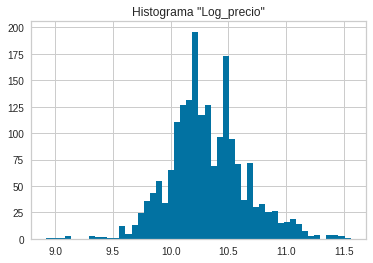

In [312]:
# Mostramos "precio" con transformación logarítmica
log_precio = np.log(model_coches.precio)
plt.hist(log_precio, bins = 50);
plt.title('Histograma "Log_precio"')

## Ensayo modelos

In [313]:
# convertimos el DataFrame al formato necesario para scikit-learn

data_backUp = model_coches.copy()


y = model_coches['precio']                      
X = model_coches.drop(columns = 'precio')      

feature_names = model_coches.columns[1:]

In [314]:
# Dividimos los datos en entrenamiento y test (75% training, 25% test)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state = 2)

print('Datos entrenamiento: ', X_train.shape)
print('Datos test: ', X_test.shape)

Datos entrenamiento:  (1445, 28)
Datos test:  (482, 28)


In [315]:
# Crear funciones logarítmica y exponencial para aplicar posteriormente sobre la variable objetivo a través de Pipelines

def func(x):
  '''Función logarítmica
  '''
  return np.log(x)

def inverse_func(x):
  '''Función exponencial
  '''
  return np.exp(x)

### Pipelines



1.   $\rightarrow$ precio --> log(precio)
2.   $\rightarrow$ MinMaxScaler(['año', 'kilometros'])



In [316]:
# Pipelines

# Escalado de características 'años' y 'kilómetros'

pre_process = ColumnTransformer(remainder = 'passthrough',
                                transformers = [('scale_data_Mx_mn', MinMaxScaler(),['años','kilometros'])])

# Aplicar escalado y transformación para realizar modelo RandomForestRegressor

model_pipeline = Pipeline(steps = [('pre_processing', pre_process),                                   
                                   ('random_forest', RandomForestRegressor(max_depth=10, random_state=2, bootstrap = True))])

# Aplicar transformación logarítmica a variable objetivo 'precio', procesar resto de Pipelines

model = TransformedTargetRegressor(regressor = model_pipeline,
                                   func = func,
                                   inverse_func = inverse_func)

In [317]:
# Entrenar modelo

model.fit(X_train, y_train)

TransformedTargetRegressor(func=<function func at 0x7efe559e6c20>,
                           inverse_func=<function inverse_func at 0x7efe559e6ef0>,
                           regressor=Pipeline(steps=[('pre_processing',
                                                      ColumnTransformer(remainder='passthrough',
                                                                        transformers=[('scale_data_Mx_mn',
                                                                                       MinMaxScaler(),
                                                                                       ['años',
                                                                                        'kilometros'])])),
                                                     ('random_forest',
                                                      RandomForestRegressor(max_depth=10,
                                                                            random_state=2))]))

In [318]:
# Evaluar modelo

model.score(X_test, y_test)

0.8827444638338343

## RANDOM FOREST REGRESSOR

### Búsqueda de hiper-parámetros con GridSearchCV

best mean cross-validation score: 0.900
best parameters: {'max_depth': 16}


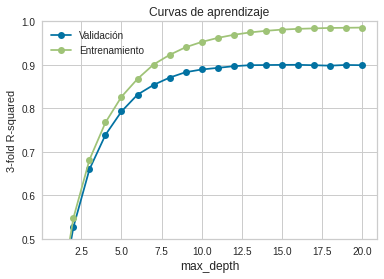

In [319]:
max_depth_arr = range(1, 20+1) 
tuned_parameters = {'max_depth': max_depth_arr} 
n_folds = 3 # ponemos este valor algo bajo para que no tarde demasiado 
clf = RandomForestRegressor(random_state=0, n_estimators=100, max_features='sqrt') 
grid = GridSearchCV(clf, param_grid=tuned_parameters, cv=n_folds, return_train_score=True) 
grid.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_)) 
print("best parameters: {}".format(grid.best_params_)) 
scores_test = np.array(grid.cv_results_['mean_test_score']) 
scores_train = np.array(grid.cv_results_['mean_train_score']) 
plt.plot(max_depth_arr, scores_test, '-o', label='Validación') 
plt.plot(max_depth_arr, scores_train, '-o', label='Entrenamiento') 
plt.xlabel('max_depth', fontsize=12) 
plt.ylabel('{}-fold R-squared'.format(n_folds)) 
plt.ylim((0.5, 1)) 
plt.legend()
plt.title("Curvas de aprendizaje")
plt.show()

#### Mejor parámetro: max_depth = 16

In [320]:
clf_RFR = RandomForestRegressor(random_state=0, n_estimators= 100, max_features = 'sqrt', max_depth=16)

### Pipelines

In [321]:
# Pipelines

# Escalado de características 'años' y 'kilómetros'

pre_process = ColumnTransformer(remainder = 'passthrough',
                                transformers = [('scale_data_Mx_mn', MinMaxScaler(),['años','kilometros'])])

# Aplicar escalado y transformación para realizar modelo RandomForestRegressor

model_pipeline = Pipeline(steps = [('pre_processing', pre_process),                                   
                                   ('random_forest', clf_RFR)])

# Aplicar transformación logarítmica a variable objetivo 'precio', procesar resto de Pipelines

model = TransformedTargetRegressor(regressor = model_pipeline,
                                   func = func,
                                   inverse_func = inverse_func)

### Ajuste del modelo

In [322]:
model_RFR = model.fit(X_train, y_train)

### Métricas obtenidas

In [323]:
R2_RFR = model_RFR.score(X_test, y_test)
R2_RFR

0.900329651288172

In [324]:
rms_RFR = mean_squared_error(y_test, model_RFR.predict(X_test), squared=False)
rms_RFR

3304.969540740131

### Comparación resultados-datos reales

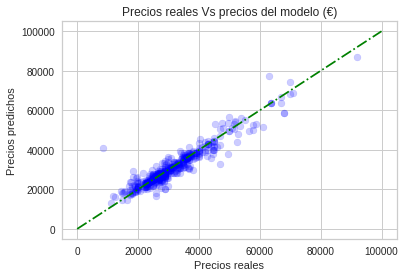

In [325]:
# Grafico para mejor comprensión de nuestras predicciones

plt.scatter(y_test, model_RFR.predict(X_test), color="blue", label = 'Precios', alpha=0.2)
plt.plot(range(100000), linestyle = 'dashdot', color = 'green')
plt.xlabel('Precios reales')
plt.ylabel('Precios predichos')
plt.title('Precios reales Vs precios del modelo (€)')
plt.show()

## GRADIENT BOOSTING REGRESSION

### Búsqueda de hiper-parámetros con GridSearchCV

In [326]:
Niterations = [10,100,500, 800] 
learningRate = [0.1, 0.05, 0.02] 
max_depth = [1,3,5,7,9]
n_folds = 3 
param_grid = {'n_estimators': Niterations, 'learning_rate': learningRate, 'max_depth': max_depth} 
clf = GradientBoostingRegressor(random_state=0, max_depth=3) 
grid = GridSearchCV(clf, param_grid=param_grid, cv=n_folds) 
grid.fit(X_train, y_train) 
print("best mean cross-validation score: {:.3f}".format(grid.best_score_)) 
print("best parameters: {}".format(grid.best_params_))

best mean cross-validation score: 0.899
best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500}


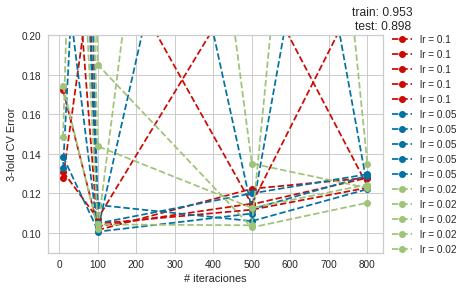

In [327]:
bt = GradientBoostingRegressor(random_state=0, **grid.best_params_) 
bt.fit(X_train, y_train) 
error = 1-grid.cv_results_['mean_test_score'].reshape(len(learningRate), len(Niterations), len(max_depth)) 
colors = ['r', 'b', 'g', 'k', 'm'] 

for i, lr in enumerate(learningRate): 
  plt.plot(Niterations,error[i,:],colors[i] + '--o', label='lr = %g' % lr) 

plt.xlabel('# iteraciones') 
plt.ylabel('{}-fold CV Error'.format(n_folds)) 
plt.title('train: %0.3f\ntest: %0.3f' % (bt.score(X_train, y_train), bt.score(X_test, y_test)), position = (1.0, 1.0)) 
plt.ylim(0.09,0.2)
plt.grid(visible = True) 
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
plt.show()

#### Mejores parámetro: max_depth = 3, learning_rate = 0.05, n_estimators= 500.
Tras probar con los valores max_depth=3 y max_depth=5, vemos que tenemos menor RMSE con 5

In [328]:
clf_GBR = GradientBoostingRegressor(random_state=0, n_estimators= 500, learning_rate = 0.05, max_features = 'sqrt', max_depth=5)

### Pipelines

In [329]:
# Pipelines

# Escalado de características 'años' y 'kilómetros'

pre_process = ColumnTransformer(remainder = 'passthrough',
                                transformers = [('scale_data_Mx_mn', MinMaxScaler(),['años','kilometros'])])

# Aplicar escalado y transformación para realizar modelo GradientBoostingRegressor

model_pipeline = Pipeline(steps = [('pre_processing', pre_process),                                   
                                   ('gradient_boost', clf_GBR)])

# Aplicar transformación logarítmica a variable objetivo 'precio', procesar resto de Pipelines

model = TransformedTargetRegressor(regressor = model_pipeline,
                                   func = func,
                                   inverse_func = inverse_func)

### Ajuste del modelo

In [330]:
model_GBR = model.fit(X_train, y_train)

### Métricas obtenidas

In [331]:
R2_GBR = model_GBR.score(X_test, y_test)
R2_GBR

0.9081637740292228

In [332]:
rms_GBR = mean_squared_error(y_test, model_GBR.predict(X_test), squared=False)
rms_GBR

3172.425897048429

### Comparación resultados-datos reales

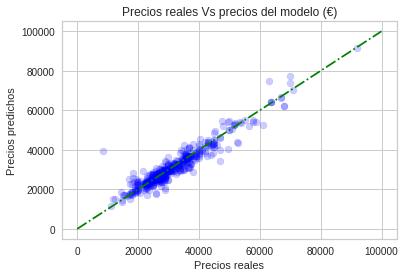

In [333]:
# Grafico para mejor comprensión de nuestras predicciones

plt.scatter(y_test, model_GBR.predict(X_test), color="blue", label = 'Precios', alpha=0.2)
plt.plot(range(100000), linestyle = 'dashdot', color = 'green')
plt.xlabel('Precios reales')
plt.ylabel('Precios predichos')
plt.title('Precios reales Vs precios del modelo (€)')
plt.show()

## SUPPORT VECTOR REGRESSOR

### Búsqueda de hiper-parámetros con GridSearchCV

In [334]:
''' Ejecutar sólo para calcular hiperparámetros, tarda mucho tiempo en ejecutar 

vectorC = np.logspace(-2,2,5) 
vectorG = np.logspace(-5, 1, 2)
param_grid = {'C': vectorC, 'gamma': vectorG} 
n_folds = 2

grid = GridSearchCV(SVR(kernel='rbf'), param_grid=param_grid, cv=n_folds, verbose=1) 
grid.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_)) 
print("best parameters: {}".format(grid.best_params_))
'''


' Ejecutar sólo para calcular hiperparámetros, tarda mucho tiempo en ejecutar \n\nvectorC = np.logspace(-2,2,5) \nvectorG = np.logspace(-5, 1, 2)\nparam_grid = {\'C\': vectorC, \'gamma\': vectorG} \nn_folds = 2\n\ngrid = GridSearchCV(SVR(kernel=\'rbf\'), param_grid=param_grid, cv=n_folds, verbose=1) \ngrid.fit(X_train, y_train)\n\nprint("best mean cross-validation score: {:.3f}".format(grid.best_score_)) \nprint("best parameters: {}".format(grid.best_params_))\n'

#### Mejores parámetro: kernel = 'rbf', gamma = 1e-05, C = 100.0

In [335]:
# Aplicamos parámetros obtenidos

clf_SVR = SVR(kernel = 'rbf', gamma = 1e-05, C = 100.0)

### Pipelines

In [336]:
# Pipelines

# Escalado de características 'años' y 'kilómetros'

pre_process = ColumnTransformer(remainder = 'passthrough',
                                transformers = [('scale_data_Mx_mn', MinMaxScaler(),['años','kilometros'])])

# Aplicar escalado y transformación para realizar modelo SVR

model_pipeline = Pipeline(steps = [('pre_processing', pre_process),                                   
                                   ('support_vector_regressor', clf_SVR)])

# Aplicar transformación logarítmica a variable objetivo 'precio', procesar resto de Pipelines

model = TransformedTargetRegressor(regressor = model_pipeline,
                                   func = func,
                                   inverse_func = inverse_func)

### Ajuste del modelo

In [337]:
model_SVR = model.fit(X_train, y_train)

### Métricas obtenidas

In [338]:
R2_SVR = model_SVR.score(X_test, y_test)
R2_SVR

0.5829437092350545

In [339]:
rms_SVR = mean_squared_error(y_test, model_SVR.predict(X_test), squared=False)
rms_SVR

6760.546598781215

### Comparación resultados-datos reales

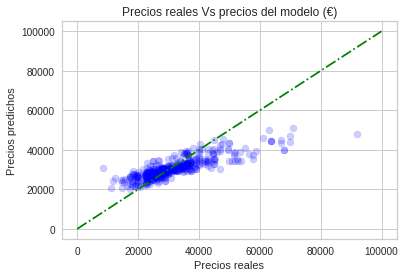

In [340]:
# Grafico para mejor comprensión de nuestras predicciones

plt.scatter(y_test, model_SVR.predict(X_test), color="blue", label = 'Precios', alpha=0.2)
plt.plot(range(100000), linestyle = 'dashdot', color = 'green')
plt.xlabel('Precios reales')
plt.ylabel('Precios predichos')
plt.title('Precios reales Vs precios del modelo (€)')
plt.show()

## ANÁLISIS GLOBAL

### Comparación modelos según predicciones

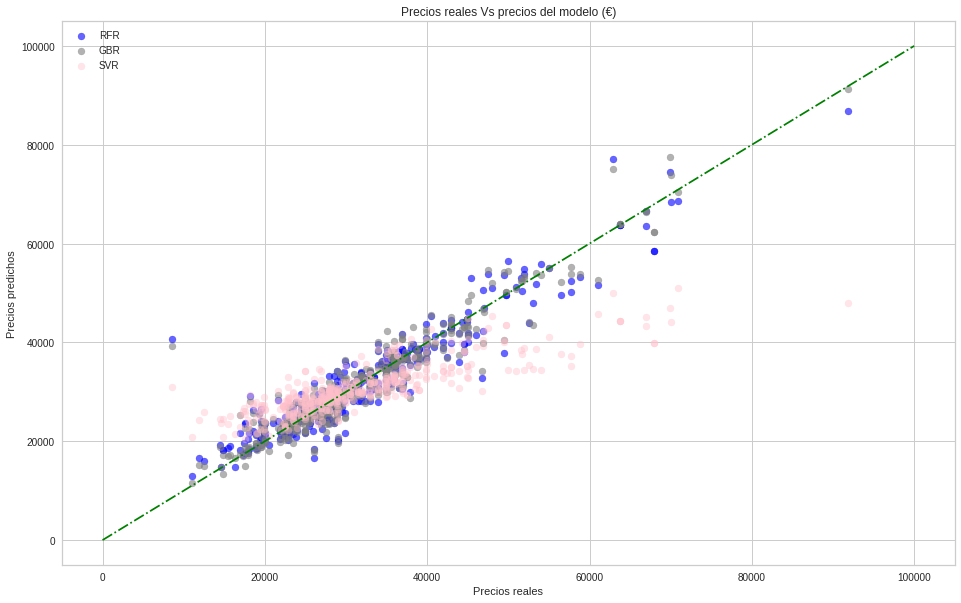

In [341]:
plt.figure(figsize=(16,10))
plt.scatter(y_test, model_RFR.predict(X_test), color="blue", label = 'RFR', alpha=0.6)
plt.scatter(y_test, model_GBR.predict(X_test), color="grey", label = 'GBR', alpha=0.6)
plt.scatter(y_test, model_SVR.predict(X_test), color="pink", label = 'SVR', alpha=0.4)
plt.plot(range(100000), linestyle = 'dashdot', color = 'green')
plt.xlabel('Precios reales')
plt.ylabel('Precios predichos')
plt.title('Precios reales Vs precios del modelo (€)')
plt.legend()
plt.show();

### Análisis de residuos en modelo Random Forest Regressor

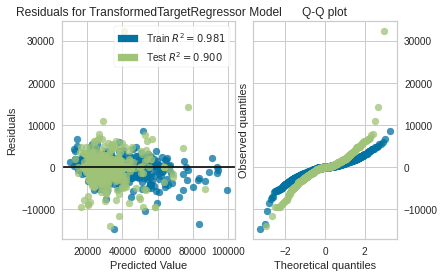

In [342]:
visualizer = ResidualsPlot(model_RFR, hist=False, qqplot=True)

visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.show();                 

### Análisis de residuos en modelo Gradient Boosted Regressor

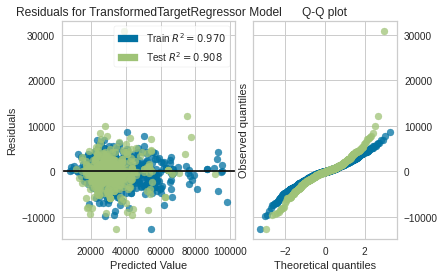

In [343]:
visualizer = ResidualsPlot(model_GBR, hist=False, qqplot=True)

visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.show() ;                

### Análisis de residuos en modelo Support Vector Regressor

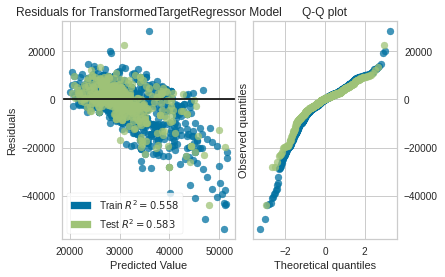

In [344]:
visualizer = ResidualsPlot(model_SVR, hist=False, qqplot=True)

visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.show()  

### Comparación sin transformación logarítmica en variable objetivo

In [345]:
clf_GBR_noLog = GradientBoostingRegressor(random_state=0, n_estimators= 500, learning_rate = 0.05, max_features = 'sqrt', max_depth=5)

In [346]:
# Pipelines

# Escalado de características 'años' y 'kilómetros'

pre_process = ColumnTransformer(remainder = 'passthrough',
                                transformers = [('scale_data_Mx_mn', MinMaxScaler(),['años','kilometros'])])

# Aplicar escalado y transformación para realizar modelo GradientBoostingRegressor sin transformar 'precio'

model_pipeline = Pipeline(steps = [('pre_processing', pre_process),                                   
                                   ('gradient_boost', clf_GBR_noLog)])

# Aplicar transformación logarítmica a variable objetivo 'precio', procesar resto de Pipelines

model = TransformedTargetRegressor(regressor = model_pipeline,
                                   func = func,
                                   inverse_func = inverse_func)

Aplicamos modelo sin utilizar pipeline de transformación de variable objetivo

In [347]:
model_GBR_noLog = model_pipeline.fit(X_train, y_train)

In [348]:
R2_GBR_noLog = model_GBR_noLog.score(X_test, y_test)
R2_GBR_noLog

0.9051816733328986

In [349]:
rms_GBR_noLog = mean_squared_error(y_test, model_GBR_noLog.predict(X_test), squared=False)
rms_GBR_noLog

3223.521831177278

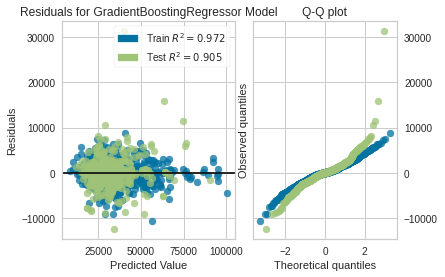

In [350]:
visualizer = ResidualsPlot(model_GBR_noLog, hist=False, qqplot=True)

visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.show() 

### Análisis de las métricas

In [351]:
# Genero dataframe con los resultados

df_global = pd.DataFrame(
    {
        'id': ['RFR','GBR','SVR','GBR_noLog'],
        'nombre': ['Random Forest Regressor', 'Gradient Boosted Regressor', 'Support Vector Regressor', 'Gradient Boosted Regressor target original'],
        'R2': [R2_RFR, R2_GBR, R2_SVR, R2_GBR_noLog],
        'RMSE': [rms_RFR, rms_GBR, rms_SVR, rms_GBR_noLog],
     })

In [352]:
# Ordeno valores

df_global_sorted = df_global.sort_values('RMSE', ascending= True)

In [353]:
df_global_sorted

,id,nombre,R2,RMSE
1,GBR,Gradient Boosted Regressor,0.908164,3172.425897
3,GBR_noLog,Gradient Boosted Regressor target original,0.905182,3223.521831
0,RFR,Random Forest Regressor,0.900330,3304.969541
2,SVR,Support Vector Regressor,0.582944,6760.546599


Aplico escalado a RMSE de 1:10000, para una mejor comparación gráfica

In [354]:
df_global_sorted['RMSE_scaled'] = df_global_sorted['RMSE'] / 10000
df_global_sorted

,id,nombre,R2,RMSE,RMSE_scaled
1,GBR,Gradient Boosted Regressor,0.908164,3172.425897,0.317243
3,GBR_noLog,Gradient Boosted Regressor target original,0.905182,3223.521831,0.322352
0,RFR,Random Forest Regressor,0.900330,3304.969541,0.330497
2,SVR,Support Vector Regressor,0.582944,6760.546599,0.676055


Formateo dataframe para graficar

In [355]:
# Damos forma formato al dataframe para mostrar gráfico en una sola figura

df_global_barplot = df_global_sorted.drop(columns=['nombre','RMSE'])
df_global_barplot = pd.melt(df_global_barplot, id_vars="id", var_name="metrics", value_name="values")

<Figure size 1008x576 with 0 Axes>

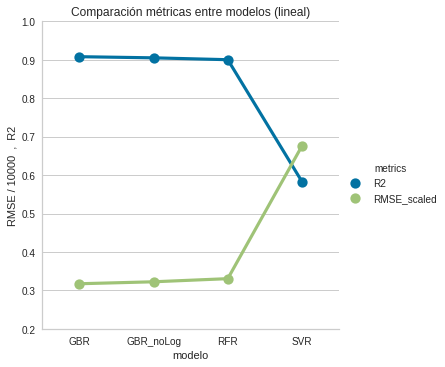

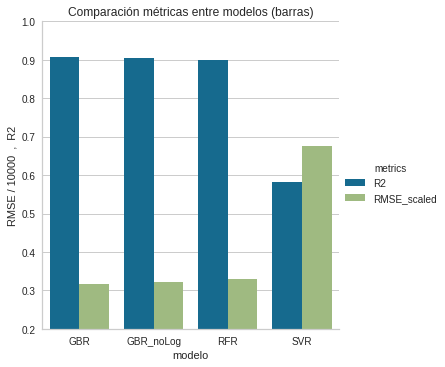

In [356]:
# Creación de gráficos comparativos

plt.figure(figsize=(14,8))
sns.catplot(x='id', y='values', hue='metrics', data=df_global_barplot, kind='point')
plt.title('Comparación métricas entre modelos (lineal)')
plt.xlabel('modelo')
plt.ylabel('RMSE / 10000  ,  R2')
plt.ylim(0.2,1.0)
sns.catplot(x='id', y='values', hue='metrics', data=df_global_barplot, kind='bar')
plt.title('Comparación métricas entre modelos (barras)')
plt.xlabel('modelo')
plt.ylabel('RMSE / 10000  ,  R2')
plt.ylim(0.2,1.0)
plt.show();